# Libraries

In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from bandit_library import *
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Defining Inputs

In [103]:
##INTERVAL AND TRADING PERIOD##

interval = '1d'
tau = 150
m = 330

trade_start_time = datetime.datetime(2019,10,11,17,30)

if interval == '1d':
    hist_start_time = trade_start_time - datetime.timedelta(days=tau)
    trade_end_time = trade_start_time + datetime.timedelta(days=m)
if interval == '1wk':
    hist_start_time = trade_start_time - datetime.timedelta(days=7*tau)
    trade_end_time = trade_start_time + datetime.timedelta(days=7*m)
    
hist_end_time = trade_end_time

# TICKERS
# tickers = ['AC.PA','ALO.PA','AI.PA','ATO.PA','CAP.PA','ORA.PA','RI.PA','TTE.PA',
#            'PINR.PA','SW.PA','SU.PA','BN.PA','PAASI.PA','PAEEM.PA','ML.PA','SK.PA']
#tickers = ['AI.PA','ALO.PA','SU.PA','SK.PA','ORA.PA']
tickers = ['AAPL','MSFT','GOOGL','AMZN','AI.PA','ORA.PA','TTE.PA','SW.PA','AC.PA']
n_assets = len(tickers)

In [104]:
data = Data(tickers)
hist_returns = data.get_data(hist_start_time,hist_end_time,interval)

Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']


# Brief Co-Dependence Analysis

In [105]:
# sns.heatmap(hist_returns.cov())
# plt.title('Covariance Matrix')

Text(0.5, 1.0, 'Spearman Correlation')

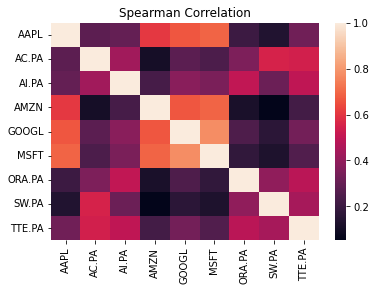

In [106]:
sns.heatmap(hist_returns.corr(method='spearman'))
plt.title('Spearman Correlation')

Let us compute the covariance matrix of our returns :

In [107]:
cov_matrix = get_cov(hist_returns)

This matrix is $\Sigma_k$ but we will need to eigen-decompose it .

We now estimate the average return $\mathbb{E}[\textbf{R}_k] \in \mathbb{R}_n $

 - $\tau$ represents the size of the training data 
 - Example : if we study an interval of 300 days, $\tau$ = 300
 - Our 'training' returns are in the interval $[k-\tau, k-1]$, hence the length is $k-1 - (k-\tau) + 1 = \tau$

NB : 
- hist_start_time = trading_start_time - $\tau$
- To ensure that the average return and the covariance matrix of assets returns $\Sigma_k$ are estimated by $(\textbf{R}_{k-\tau},..,\textbf{R}_{k-1})$

In [108]:
k=1

In [109]:
E_R,Sigma = calculate_return_and_cov(hist_returns,k,tau,interval,trade_start_time,heavy_tailed=False)

The next step is to decompose of the covariance matrix :

In [110]:
Lambda, H = eigen_decomposition(Sigma)
Lambdas = np.diag(Lambda)

- Lambda corresponds to $\Lambda_k$
- Lambdas is a numpy array containing all the eigenvalues (the diagonal of $\Lambda_k$)
- H corresponds to $\mathcal{H}_k$

Now we compute the renormalized similarity matrices and eigenvalues :

In [111]:
Lambda_norm, H_norm = normalization(n_assets,Lambda,H)
Lambdas_norm = np.diag(Lambda_norm)

In [112]:
Sigma_tilde, Lambda_tilde = np.matmul(np.matmul(H_norm,Sigma),np.transpose(H_norm)),np.matmul(np.matmul(H_norm,Sigma),np.transpose(H_norm))

- Lambda_tilde and Sigma_tilde corresponds to $\tilde{\Lambda_k}$
- H_norm corresponds to $\tilde{\mathcal{H}_k}$

We have a constructed a set of n uncorrelated portfolios with return $\textbf{H}_k^{T} \textbf{R}_k$

In [113]:
portfolio_returns = np.matmul(np.transpose(H),np.array(E_R))

At time $t_k$ the return of the i-th orthogonal portfolio is estimated as $\tilde{H_{k,i}}R_{k,i}$
              and the variance with $\tilde{\lambda_{k,i}}$                  

In [114]:
SR = get_sharpe_ratios(H,Lambdas,E_R)
SR

array([ 33.12033603,  67.62308274,  87.31984498, 102.40868975,
       105.69039885, 107.56174305, 123.94018339, 152.03955022,
       195.71619484])

# All in One - Algorithm Orthogonal Bandit Portfolio

In [115]:
#interval = '1d'
tau = 300
m = 250
l = 2 #n_assets / 2 looks good for small n_assets

In [116]:
returns,returnsEW,CW_OBP,CW_EW,weights,choices_inf,choices_sup,SR_obp,SR_ew = run_obp(
    interval=interval,tau=tau,l=l,m=m,
    hist_start_time=hist_start_time,hist_end_time=hist_end_time,trade_start_time=trade_start_time,tickers=tickers,heavy_tailed=False)
returns_JS,returnsEW_JS,CW_OBP_JS,CW_EW_JS,weights_JS,choices_inf_JS,choices_sup_JS,SR_obp,SR_ew = run_obp_JS(
    interval=interval,tau=tau,l=l,m=m,
    hist_start_time=hist_start_time,hist_end_time=hist_end_time,trade_start_time=trade_start_time,tickers=tickers,heavy_tailed=False)

Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']


Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']


In [117]:
mean_return = np.mean(returns) # +1 if gross, nothing if net return
mean_return_ew = np.mean(returnsEW)
std_obp = np.std(returns)
std_ew = np.std(returnsEW)
obp_SR = mean_return/std_obp
ew_SR = mean_return_ew/std_ew
obp_JS_SR = np.mean(returns_JS)/np.std(returns_JS)

n_digits = 3 # number of decimals to round the results
print('PORTFOLIO INFORMATIONS')
print('------------')
print('OBP - Sharpe Ratio :',round(obp_SR,n_digits))
print('OBP James Stein - Sharpe Ratio :',round(obp_JS_SR,n_digits))
print('EW - Sharpe Ratio :',round(ew_SR,n_digits))
print('------------')
print('Cumulative Wealth OBP',CW_OBP[0:3])
print('Cumulative Wealth EW',CW_EW[0:3])
print('Cumulative Wealth OBP JS',CW_OBP_JS[0:3])
#print('Cumulative Wealth EW JS',CW_EW_JS[0:3]) # we print the first values 
print('------------')
print('Choices Inf',choices_inf)
print('Choices Sup',choices_sup)

PORTFOLIO INFORMATIONS
------------
OBP - Sharpe Ratio : 0.474
OBP James Stein - Sharpe Ratio : 0.474
EW - Sharpe Ratio : 1.052
------------
Cumulative Wealth OBP [1.0006282839701963, 1.0012569626811398, 1.00188603638084]
Cumulative Wealth EW [1.0008150363823498, 1.001630737049004, 1.0024471025413788]
Cumulative Wealth OBP JS [1.0006282839701963, 1.0012569626811398, 1.00188603638084]
------------
Choices Inf [0, 250]
Choices Sup [0, 0, 0, 1, 0, 1, 248]


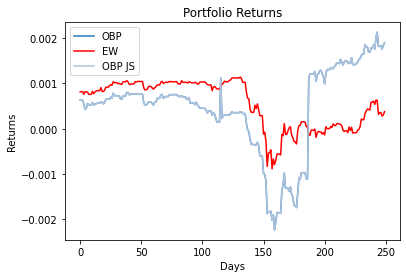

In [118]:
plt.plot(returns[:],label='OBP')
plt.plot(returnsEW[:],'r',label='EW') # : to specifiy indexes you want to plot easily
plt.plot(returns_JS[:],'lightsteelblue',label='OBP JS')
plt.title('Portfolio Returns')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.legend()
plt.show()

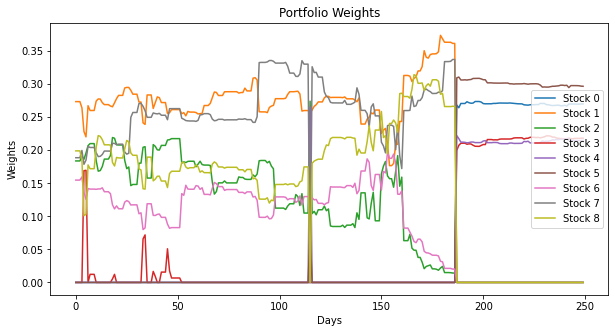

In [119]:
weights_per_stock = np.zeros((n_assets,m))
for i in range(n_assets):
    weights_per_stock[i] = [weights[j][i] for j in range(len(weights))]

plt.figure(figsize=(10,5))       
for i in range(n_assets):
    plt.plot(weights_per_stock[i],label='Stock '+str(i))
plt.title('Portfolio Weights')
plt.xlabel('Days')
plt.ylabel('Weights')
plt.legend()
plt.show()

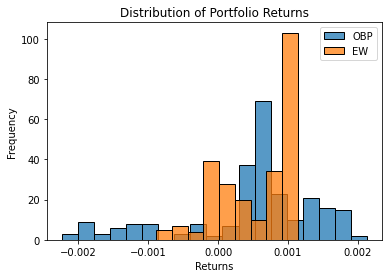

In [120]:
sns.histplot(returns,label='OBP')
sns.histplot(returnsEW,label='EW')
plt.title('Distribution of Portfolio Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Text(0.5, 1.0, 'Comparing OBP and EW Portfolios CW')

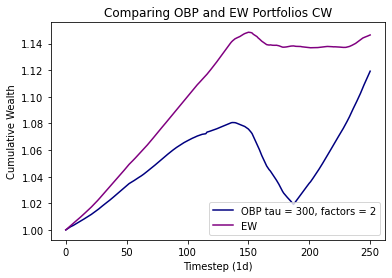

In [121]:
plt.plot(np.arange(0,m+1,1),([1]+CW_OBP),color='navy',label=f'OBP tau = {tau}, factors = {l}')
plt.plot(np.arange(0,m+1,1),[1]+CW_EW,color='purple',label='EW')
plt.ylabel('Cumulative Wealth')
plt.xlabel(f'Timestep ({interval})')
plt.legend()
plt.title('Comparing OBP and EW Portfolios CW')

Text(0.5, 1.0, 'Difference between Vanilla and James Stein returns over time')

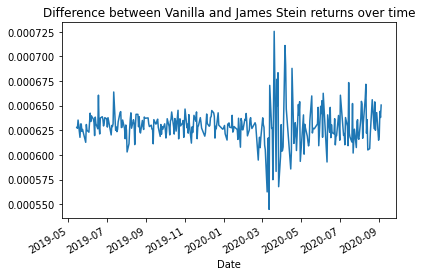

In [123]:
(hist_returns['AC.PA']-James_Stein(hist_returns)['AC.PA']).plot()
plt.title('Difference between Vanilla and James Stein returns over time')

In [124]:
l=3

In [125]:
obp_test2 = OBP(interval,l,m,tau,hist_start_time,hist_end_time,trade_start_time,tickers,False)
obp_test1 = OBP(interval,l,m,tau,hist_start_time,hist_end_time,trade_start_time,tickers,False)
obp_test3 = OBP(interval,l,m,tau,hist_start_time,hist_end_time,trade_start_time,tickers,False)

In [126]:
obp_test2.get_optimal_l()
obp_test3.get_optimal_l()

obp_test1.get_optimal_tau()
obp_test3.get_optimal_tau()

obp_test1.run_obp()
obp_test2.run_obp()
obp_test3.run_obp()

Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSF

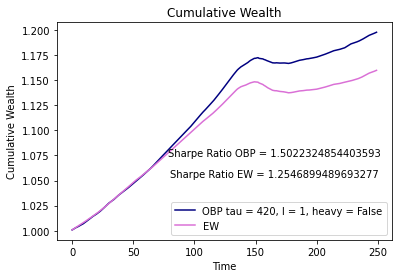

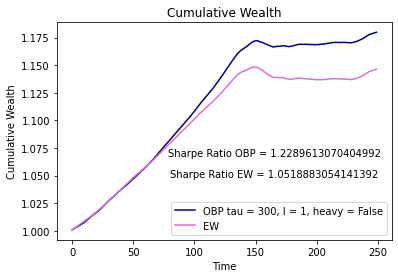

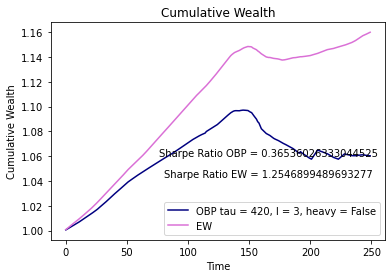

In [127]:
obp_test3.plot_CW()
obp_test2.plot_CW()
obp_test1.plot_CW()

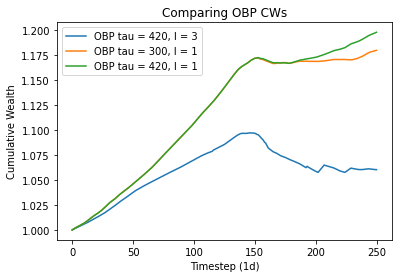

In [128]:
# compare the CWs
plt.plot(np.arange(0,m+1,1),[1]+obp_test1.CW_OBP,label=f'OBP tau = {obp_test1.tau}, l = {obp_test1.l}')
plt.plot(np.arange(0,m+1,1),[1]+obp_test2.CW_OBP,label=f'OBP tau = {obp_test2.tau}, l = {obp_test2.l}')
plt.plot(np.arange(0,m+1,1),[1]+obp_test3.CW_OBP,label=f'OBP tau = {obp_test3.tau}, l = {obp_test3.l}')
plt.ylabel('Cumulative Wealth')
plt.xlabel(f'Timestep ({interval})')
plt.legend()
plt.title('Comparing OBP CWs')
plt.show()

Heavy Tails

In this section we study the OBP algorithm when input returns are sampled from a heavy tailed distribution.

In [129]:
l = 1

In [130]:
obp_heavy1 = OBP(interval,l,m,tau,hist_start_time,hist_end_time,trade_start_time,tickers,True)
obp_heavy2 = OBP(interval,l,m,tau,hist_start_time,hist_end_time,trade_start_time,tickers,False)

In [131]:
obp_heavy1.get_optimal_l()
obp_heavy2.get_optimal_l()

obp_heavy1.run_obp()
obp_heavy2.run_obp()

Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']
Asset : ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'AI.PA', 'ORA.PA', 'TTE.PA', 'SW.PA', 'AC.PA']


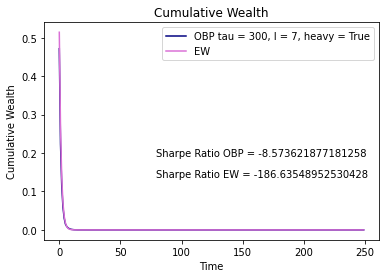

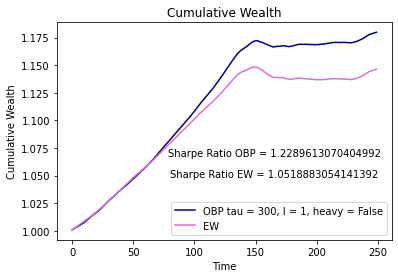

In [132]:
obp_heavy1.plot_CW()
obp_heavy2.plot_CW()